In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pysptools.eea import PPI
from pysptools.abundance_maps import FCLS

from hsu import utils, models, constraints, sampling

from importlib import reload

from cfollmer.objectives import relative_entropy_control_cost, stl_control_cost_aug
from cfollmer.drifts import SimpleForwardNetBN, ScoreNetwork, ResNetScoreNetwork, DecoupledDrift
from cfollmer.sampler_utils import FollmerSDE, FollmerSDE_STL, DecoupledSDE

from tqdm import tqdm

import gc

In [2]:
reload(utils)
reload(sampling)
reload(constraints)
reload(models)

<module 'hsu.models' from '/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/hsu/models.py'>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
indian_pines_data = utils.loadmat("../data/Indian_pines_corrected.mat")
radiances = indian_pines_data["indian_pines_corrected"]
reflectances = radiances / radiances.max()
indian_pines_gt = indian_pines_gt = utils.loadmat("../data/Indian_pines_gt.mat")
gt = indian_pines_gt["indian_pines_gt"]

In [5]:
R = 3

In [6]:
ppi = PPI()
fcls = FCLS()

M = ppi.extract(reflectances, R)
A_fcls = fcls.map(reflectances, M)

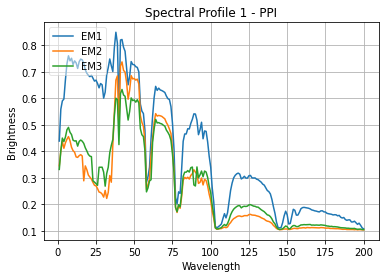

In [7]:
ppi.display()

In [8]:
def plot_abundances(A, fn=None, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(R * 5, 5))
    ax.imshow(A)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title is not None:
        ax.set_title(title)
    if fn is not None:
        fig.savefig(fn, dpi=300, bbox_inches="tight")

In [9]:
A_fcls = torch.tensor(A_fcls, device=device)

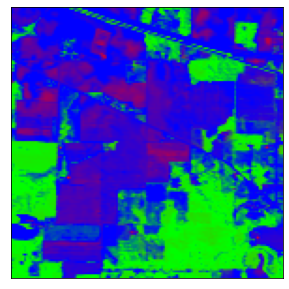

In [10]:
plot_abundances(A_fcls.cpu())

In [11]:
M = torch.tensor(M, device=device, dtype=torch.float)
Y = torch.tensor(reflectances, device=device, dtype=torch.float)

In [13]:
def U_NCM(A, sigma2_endm):
    return models.likelihood_NCM(Y, M, A, sigma2_endm)
U_NCM = constraints.apply_constraints(U_NCM, models.constraints_NCM)
grad_U_NCM = utils.make_grad_func(U_NCM)

In [14]:
w, h = Y.shape[:2]
A = torch.rand((w, h, R), device=device)
A = A / A.sum(dim=-1)[..., None]
A = A[..., :-1]
sigma2_endm = torch.tensor([0.5], device=device)
sigma2_noise = torch.tensor([0.5], device=device)

In [15]:
def step_sizes(step, var):
    if var == 0:
        return 1 / (1 + step)**0.55
    elif var == 1:
        return 1e-6 / (100 + step)**0.55

In [16]:
primal_vars = (A, sigma2_endm)
dual_vars = models.constraints_LMM.h_grad(*primal_vars)

In [17]:
dual_samples = sampling.ula(dual_vars, grad_U_NCM, step_sizes, n_steps = 10000, verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 788.88it/s]


In [18]:
primal_samples = models.constraints_LMM.h_dual_grad(*dual_samples)

In [19]:
A_samples = utils.extend_simplex(primal_samples[0])

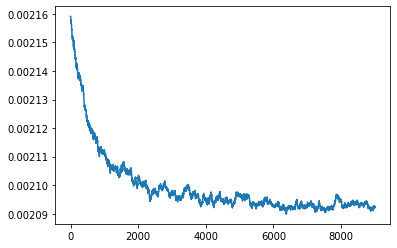

In [20]:
plt.plot(primal_samples[1][1000:].cpu())

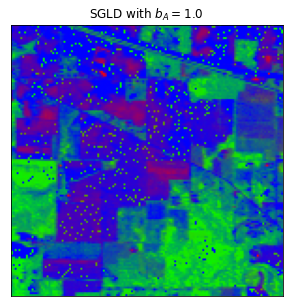

In [21]:
plot_abundances(torch.mean(A_samples[-20:], dim=0).cpu(), fn="indian_pines_sgld_poor.png", title=r"SGLD with $b_A = 1.0$")

In [22]:
a_list = [1e-0, 1e-1,1e-2]
b_list = [1e0, 1e1, 1e2, 1e3]

In [23]:
mean_images = []
for a in a_list:
    
    images = []
    
    for b in b_list:
        
        def step_sizes_(step, var):
            if var == 0:
                return a / (b + step)**0.55
            if var == 1:
                return 1e-6 / (100 + step)**0.55
        
        primal_vars = (A, sigma2_endm)
        dual_vars = models.constraints_LMM.h_grad(*primal_vars)
        dual_samples = sampling.ula(dual_vars, grad_U_NCM, step_sizes_, n_steps = 10000, verbose=True)
        primal_samples = models.constraints_NCM.h_dual_grad(*dual_samples)
        A_samples = utils.extend_simplex(primal_samples[0])
        A_mean = torch.mean(A_samples[5000:], dim=0)
        
        images.append(A_mean)
    
    mean_images.append(images)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 793.43it/s]


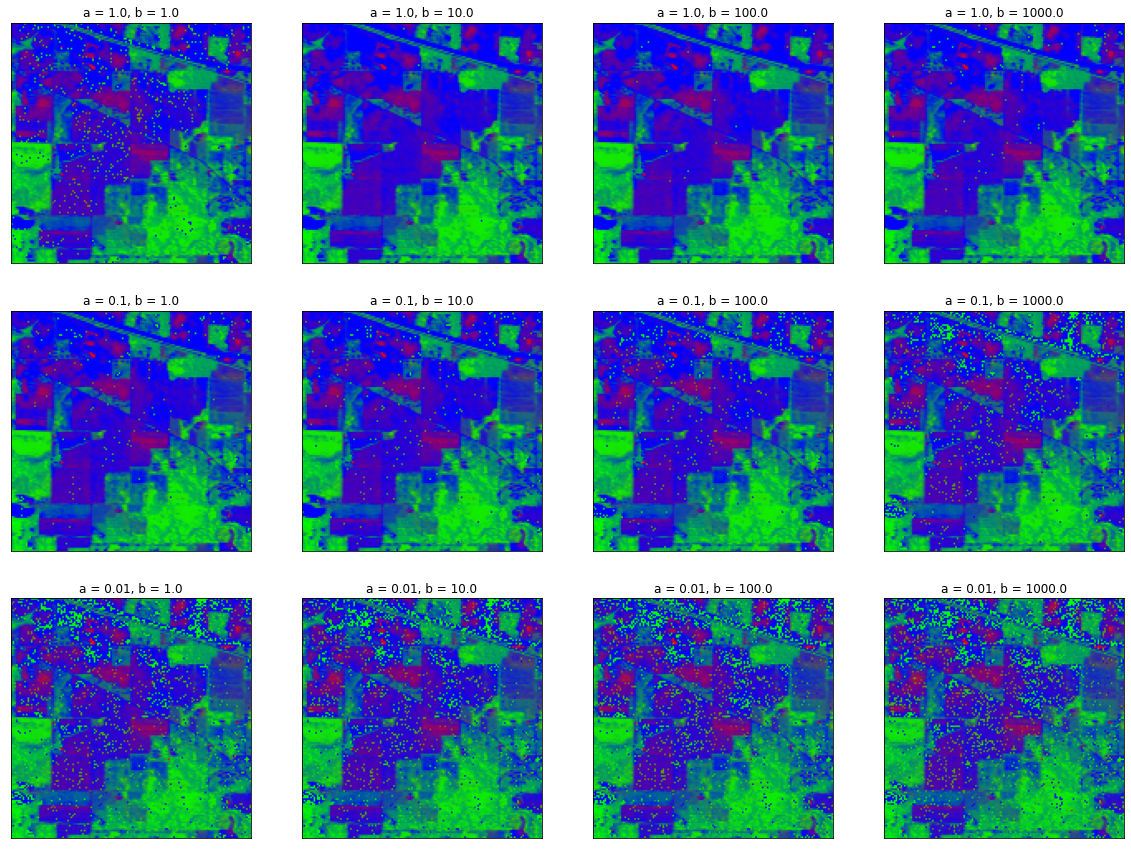

In [28]:
fig, axes = plt.subplots(nrows=len(a_list), ncols=len(b_list), figsize=(len(b_list) * 5, len(a_list) * 5))

for i in range(len(a_list)):
    for j in range(len(b_list)):
        axes[i][j].set_title(r"a = {}, b = {}".format(a_list[i], b_list[j]))
        axes[i][j].imshow(mean_images[i][j].cpu())
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        
fig.savefig("SGLD_sensitivity.png", dpi=300, bbox_inches="tight")

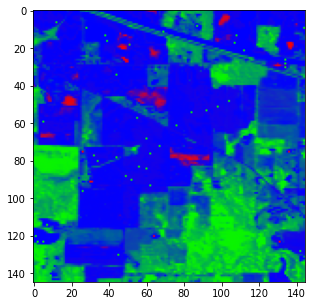

In [186]:
plot_abundances(torch.mean(A_samples[1000:], dim=0).cpu())

In [45]:
gamma = 0.2**2
n_iterations = 2000
param_batch_size = 32
dim = 1 + w * h * (R - 1)

In [46]:
def log_posterior(params):
    sigma2_endm = params[-1]
    A = params[:-1].view(w, h, R - 1)
    return U_NCM(A, sigma2_endm)

log_posterior_batch = torch.vmap(log_posterior)

/tmp/ipykernel_4107848/2643898390.py:6: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  log_posterior_batch = torch.vmap(log_posterior)


In [47]:
def train(gamma, n_iterations, param_batch_size, dt=0.05, stl=False):
    if stl:
        sde = FollmerSDE_STL(gamma, ResNetScoreNetwork(input_dim=dim)).to(device)
#         sde = FollmerSDE_STL(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    else:
        sde = FollmerSDE(gamma, ResNetScoreNetwork(input_dim=dim)).to(device)
    #sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
#     sde = FollmerSDE(gamma, HSUDrift(w, h, 4)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-5)

    losses = []

    for i in tqdm(range(n_iterations)):
            
        optimizer.zero_grad()
        
        if stl:
                loss = stl_control_cost_aug(sde, log_posterior_batch, param_batch_size=param_batch_size, dt=dt, device=device)
        else:
                loss = relative_entropy_control_cost(sde, log_posterior_batch, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()

        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
        
        if stl: # double check theres no references left
                sde.drift_network_detatched.load_state_dict((sde.drift_network.state_dict()))
        
        if i % 100 == 0:
            gc.collect()
    
    losses = np.array(losses)
    
    return sde, losses

In [20]:
gammas = torch.linspace(0.1, 1.0, 5, device=device)**2
for i in range(5):
    sde, losses = train(gammas[i], n_iterations, param_batch_size, stl=False)
    torch.save(sde.state_dict(), "weights/hsu/weights-{:d}.pt".format(i))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:06<00:00,  4.69it/s]


In [29]:
sde, losses = train(gamma, n_iterations, param_batch_size, stl=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:07<00:00,  4.10it/s]


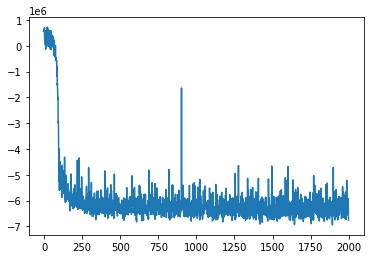

In [21]:
plt.plot(losses)

In [46]:
torch.save(sde.state_dict(), "weights/hsu_resnet_stl_gamma_07.pt")

In [27]:
sde = FollmerSDE_STL(gamma, ResNetScoreNetwork(input_dim=dim)).to(device)
sde.load_state_dict(torch.load("weights/hsu_resnet_stl.pt"))

<All keys matched successfully>

In [48]:
gammas = torch.linspace(0.1, 1.0, 5, device=device)**2

In [49]:
mean_images = []
for i in range(5):
    sde = FollmerSDE(gammas[i], ResNetScoreNetwork(input_dim=dim)).to(device)
    sde.load_state_dict(torch.load("weights/hsu/weights-{}.pt".format(i)))

    with torch.no_grad():
        param_samples = sde.sample(20, dt=0.001, device=device)

    A_samples_dual = param_samples[:, :-1]
    sigma2_noise_samples_dual = param_samples[:, -1]
    A_samples_dual = A_samples_dual.view(-1, w, h, R - 1)
    A_samples, sigma2_noise_samples = models.constraints_NCM.h_dual_grad(A_samples_dual, sigma2_noise_samples_dual)
    A_samples = utils.extend_simplex(A_samples)
    mean_images.append(torch.mean(A_samples, dim=0).cpu())

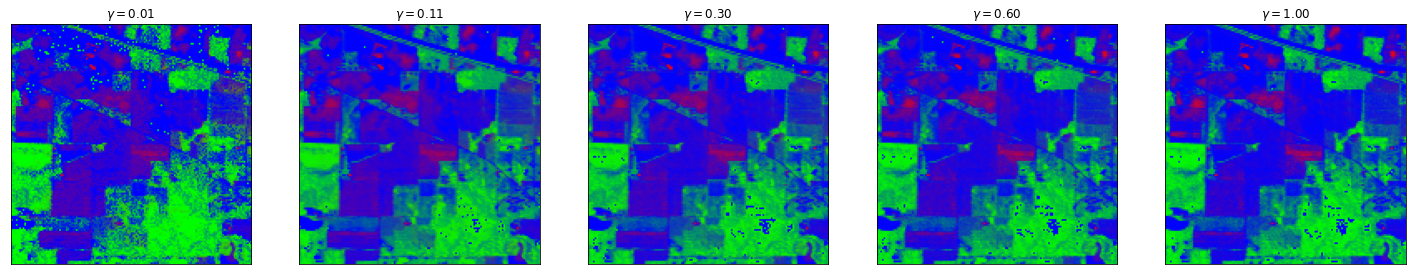

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

for i in range(5):
    axes[i].imshow(mean_images[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(r"$\gamma = {:.2f}$".format(gammas[i]))

fig.savefig("nsfs-sensitivity.png", dpi=300, bbox_inches="tight")

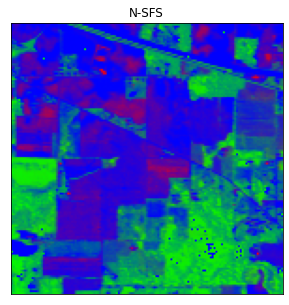

In [59]:
sde = FollmerSDE(gammas[1], ResNetScoreNetwork(input_dim=dim)).to(device)
sde.load_state_dict(torch.load("weights/hsu/weights-{}.pt".format(1)))

with torch.no_grad():
    param_samples = sde.sample(20, dt=0.001, device=device)

A_samples_dual = param_samples[:, :-1]
sigma2_noise_samples_dual = param_samples[:, -1]
A_samples_dual = A_samples_dual.view(-1, w, h, R - 1)
A_samples, sigma2_noise_samples = models.constraints_NCM.h_dual_grad(A_samples_dual, sigma2_noise_samples_dual)
A_samples = utils.extend_simplex(A_samples)
plot_abundances(torch.mean(A_samples, dim=0).cpu(), fn="indian_pines_nsfs.png", title="N-SFS")

## Decoupled Drift training

In [31]:
gamma = 0.2**2

data_size = 145 ** 2

n_iterations = 2000
param_batch_size = 32
data_batch_size = 512

local_dim = R - 1
global_dim = 1
data_dim = Y.shape[-1]

In [32]:
Y_flat = Y.reshape(data_size, -1)

In [33]:
def log_likelihood(y, params):
    sigma2_endm = params[0]
    a = params[1:]
    a = a.view(data_batch_size, local_dim)
    
    return models.likelihood_NCM(y, M, a, sigma2_endm)

def log_posterior(y, params):
    return data_batch_size / data_size * log_likelihood(y, params)

def log_posterior_batch(y, params_batch):
    f = lambda params : log_posterior(y, params)
    f = torch.vmap(f)
    return f(params_batch)

In [34]:
def train(gamma, n_iterations, data_batch_size, param_batch_size, dt=0.05, lr=1e-5):
    local_drift = DecoupledDrift(local_dim=local_dim, global_dim=global_dim, data_dim=data_dim)
    global_drift = SimpleForwardNetBN(input_dim=global_dim)
    
    sde = DecoupledSDE(gamma, global_drift, local_drift, global_dim, local_dim, data_dim).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=lr)

    losses = []

    for i in tqdm(range(n_iterations)):
        
        perm = torch.randperm(data_size)
        y = Y_flat[perm[:data_batch_size]]
        
        def U(A, sigma2_endm):
            return data_size / data_batch_size * models.likelihood_NCM(y, M, A, sigma2_endm)
        
        U = constraints.apply_constraints(U, models.constraints_NCM)
        
        def log_posterior(params):
            sigma2_endm = params[0]
            A = params[1:]
            A = A.view(data_batch_size, local_dim)
            
            return U(A, sigma2_endm)
        
        log_posterior_batch = torch.vmap(log_posterior)
        
        optimizer.zero_grad()
        
        sde.data = y
        
        loss = relative_entropy_control_cost(sde, log_posterior_batch, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()

        losses.append(loss.detach().cpu().numpy())
        optimizer.step()
        
        if i % 100 == 0:
            gc.collect()
    
    losses = np.array(losses)
    
    return sde, losses

In [36]:
gammas = torch.linspace(0.1, 1.0, 5, device=device)**2

In [18]:
for i in range(5):
    sde, losses = train(gammas[i], n_iterations, data_batch_size, param_batch_size, lr=1e-3)
    torch.save(sde.state_dict(), "weights/hsu/weights-decoupled-{:d}.pt".format(i))

  0%|                                                                                                                                                                             | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_3762450/2030254394.py:27: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  log_posterior_batch = torch.vmap(log_posterior)
/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-b

In [37]:
mean_images = []
for i in range(5):
    local_drift = DecoupledDrift(local_dim=local_dim, global_dim=global_dim, data_dim=data_dim)
    global_drift = SimpleForwardNetBN(input_dim=global_dim)
    
    sde = DecoupledSDE(gammas[i], global_drift, local_drift, global_dim, local_dim, data_dim).to(device)
    
    sde.load_state_dict(torch.load("weights/hsu/weights-decoupled-{}.pt".format(i)))
    sde.data = Y_flat
    with torch.no_grad():
        param_samples = sde.sample(20, dt=0.001, device=device)

    A_samples_dual = param_samples[:, 1:]
    sigma2_noise_samples_dual = param_samples[:, 0]
    A_samples_dual = A_samples_dual.view(-1, w, h, R - 1)
    A_samples, sigma2_noise_samples = models.constraints_NCM.h_dual_grad(A_samples_dual, sigma2_noise_samples_dual)
    A_samples = utils.extend_simplex(A_samples)
    mean_images.append(torch.mean(A_samples, dim=0).cpu())

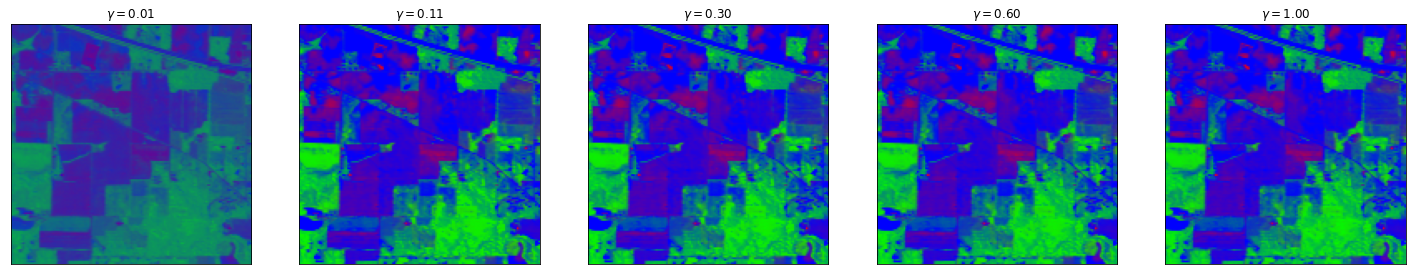

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

for i in range(5):
    axes[i].imshow(mean_images[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(r"$\gamma = {:.2f}$".format(gammas[i]))

fig.savefig("nsfs-decoupled-sensitivity.png", dpi=300, bbox_inches="tight")

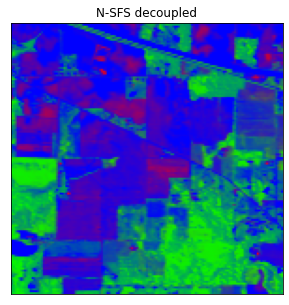

In [64]:
local_drift = DecoupledDrift(local_dim=local_dim, global_dim=global_dim, data_dim=data_dim)
global_drift = SimpleForwardNetBN(input_dim=global_dim)

sde = DecoupledSDE(gammas[1], global_drift, local_drift, global_dim, local_dim, data_dim).to(device)

sde.load_state_dict(torch.load("weights/hsu/weights-decoupled-{}.pt".format(1)))
sde.data = Y_flat
with torch.no_grad():
    param_samples = sde.sample(20, dt=0.001, device=device)

A_samples_dual = param_samples[:, 1:]
sigma2_noise_samples_dual = param_samples[:, 0]
A_samples_dual = A_samples_dual.view(-1, w, h, R - 1)
A_samples, sigma2_noise_samples = models.constraints_NCM.h_dual_grad(A_samples_dual, sigma2_noise_samples_dual)
A_samples = utils.extend_simplex(A_samples)
plot_abundances(torch.mean(A_samples, dim=0).cpu(), fn="indian_pines_nsfs_decoupled.png", title="N-SFS decoupled")